Второй вариант финального проекта, продолжаю тему e-learning, начатую в промежуточном проекте :)

# Задание 1

Предлагаем Вам ответить на следующие вопросы:

1. На какие метрики Вы смотрите в ходе анализа и почему?

2. Имеются ли различия в показателях и с чем они могут быть связаны?

3. Являются ли эти различия статистически значимыми?

4. Стоит ли запускать новую механику на всех пользователей?

In [101]:
# импорт библиотек
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
from scipy import stats
from scipy.stats import norm 
import seaborn as sns
from tqdm.auto import tqdm # для функции бутстрапа
import matplotlib.pyplot as plt # для функции бутстрапа
from scipy.stats import mannwhitneyu

import pandahouse as ph # Для работы с кликхаус

In [102]:
# # Для загрузки из своей директории локально

# groups = pd.read_csv('Проект_2_groups.csv', sep=';')
# groups_add = pd.read_csv('Проект_2_group_add.csv')
# active_studs = pd.read_csv('Проект_2_active_studs.csv')
# checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [103]:
# Загружаю файлы из яндекс-диска

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
url_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
url_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
url_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

groups = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=url_groups))).json()['href'], sep=';')
groups_add = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=url_groups_add))).json()['href'], sep=',')
active_studs = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=url_active_studs))).json()['href'], sep=';')
checks = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=url_checks))).json()['href'], sep=';')

Далее посмотрю файлы отдельно: какие данные, сколько, типы данных, количество строк

In [104]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [105]:
groups.dtypes

id      int64
grp    object
dtype: object

In [106]:
groups.id.nunique()

74484

In [107]:
groups.shape

(74484, 2)

In [108]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [109]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [110]:
groups_add.id.nunique()

92

In [111]:
groups_add.shape

(92, 2)

In [112]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [113]:
active_studs.dtypes

student_id    int64
dtype: object

In [114]:
active_studs.student_id.nunique()

8341

In [115]:
active_studs.shape

(8341, 1)

In [116]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [117]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [118]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [119]:
checks.shape

(541, 2)

In [120]:
# проверю, есть ли пользователи из дополнительной группы в датафрейме active studs
groups_add.query('id in @active_studs.student_id').shape[0]

13

Получается 13 студетнов из доп.группы учтены

In [121]:
# проверю, есть ли пользователи из дополнительной группы в датафрейме checks
groups_add.query('id in @checks.student_id').shape[0]

1

Получается 1 студент из доп.группы учтён

In [122]:
# объединю датафреймы groups и groups_add
groups_total = pd.concat([groups, groups_add], names=['id', 'grp'])
groups_total.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [123]:
# в groups 74484 строки, в groups_add 92. Проверю всё ли корректно объединилос
groups_total.shape

(74576, 2)

In [124]:
74484+92

74576

Новый даатфрейм groups_total ок

In [125]:
# сколько пользоватеелй в группе А?
groups_total.query('grp == "A"').shape[0]

14693

In [126]:
# сколько пользоватеелй в группе В?
groups_total.query('grp == "B"').shape[0]

59883

In [127]:
# проверяю есть ли студенты, которые оплатили, на отсутствовали на платформе в дни эксперимента
paid_but_not_used = checks.query('student_id not in @active_studs.student_id')
paid_but_not_used

,student_id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


Есть 149 пользователей, оплативших, но не участоввавших. Потенциально они могут являться "ошибками" оплаты, например, трназакции "зависли" и были обратотаны в день эксперимента, либо это могут быть некие автоплатежи, либо, как в анекдоте про таксиста: "заплатил и не поехал"

In [128]:
# распределение оплативших пользователей по группам оплативших
groups_total.query('id in @checks.student_id').grp.value_counts()

B    434
A    107
Name: grp, dtype: int64

In [129]:
groups_total.query('id in @checks.student_id').grp.value_counts().sum()

541

In [130]:
# распределение "не поехавших" пользователей по группам
groups_total.query('id in @paid_but_not_used.student_id').grp.value_counts()

B    120
A     29
Name: grp, dtype: int64

In [131]:
groups_total.query('id in @paid_but_not_used.student_id').grp.value_counts().sum()

149

In [132]:
# распределение активных пользователей по группам
groups_total.query('id in @active_studs.student_id').grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [133]:
groups_total.query('id in @active_studs.student_id').grp.value_counts().sum()

8341

In [134]:
# распределение активных и оплативших пользователей по группам
groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

In [135]:
groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts().sum()

392

In [136]:
# проверка активных и оплативших
541-149

392

Совпадает :)

In [137]:
# распределение активных но не оплативших
groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()

B    6489
A    1460
Name: grp, dtype: int64

In [138]:
groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts().sum()

7949

In [139]:
# проверка активных и неоплативших
8341-392

7949

И тут совпадает :)

<b> Промежуточные итоги #1 </b>

На данном этапе можно выделить несколько групп пользователей, с которыми далее я предполагаю работать:

1. Активные (зашли на сайт во время эксперимента)

2. Оплатившие + активные

3. Оплативышие + не активные

Последняя группа - не понятно откуда берётся, из условий задачи не понятно, возможна ли в принципе ситуация оплаты при неучастии. Как я уже отметил выше, возможно это "ошибочные" пользователи, природа ошибки может быть различной, так что в дальнейшей работе я не буду их учитывать. 

А на базе активных и (оплативших + активных) буду вести дальнейшее исследование

In [140]:
# объединю активных с оплатившими
active_checks = (active_studs
                .merge(checks, how='left', on='student_id')
                .rename(columns={'student_id': 'id'}))
active_checks.head()

,id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN


In [141]:
# проверю не только ли Na в столбце rev?
active_checks.rev.nunique()

38

In [142]:
# объединю активных оплативших с groups_total по id
active_total = active_checks.merge(groups_total, on='id')
active_total

,id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B
...,...,...,...
8336,1794344,NaN,B
8337,296883,NaN,B
8338,3598448,NaN,B
8339,3610547,290.0,B


In [143]:
# добавлю колонку со статусом платежа и заменю Nan на нули
active_total['pay'] = active_total.rev.apply(lambda x: 0 if np.isnan(x) else 1)
active_total

,id,rev,grp,pay
0,581585,NaN,A,0
1,5723133,NaN,A,0
2,3276743,NaN,B,0
3,4238589,NaN,A,0
4,4475369,NaN,B,0
...,...,...,...,...
8336,1794344,NaN,B,0
8337,296883,NaN,B,0
8338,3598448,NaN,B,0
8339,3610547,290.0,B,1


In [144]:
active_total.pay.nunique()

2

In [145]:
active_total['rev'] = active_total.rev.fillna(0)
active_total

,id,rev,grp,pay
0,581585,0.0,A,0
1,5723133,0.0,A,0
2,3276743,0.0,B,0
3,4238589,0.0,A,0
4,4475369,0.0,B,0
...,...,...,...,...
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0
8339,3610547,290.0,B,1


In [146]:
active_total.rev.nunique()

39

In [147]:
active_total_paid = active_total.query('rev > 0')
active_total_paid

,id,rev,grp,pay
62,1184303,1530.0000,A,1
67,3354191,1900.0001,B,1
77,3278734,1900.0000,B,1
99,720651,1980.0000,A,1
193,1232221,1900.0000,B,1
...,...,...,...,...
8201,3890326,199.0000,B,1
8204,1390994,398.0000,A,1
8263,1516339,290.0000,A,1
8277,3910596,597.0000,B,1


In [148]:
# вся группа А
a_all = active_total.query('grp == "A"')
a_all

,id,rev,grp,pay
0,581585,0.0,A,0
1,5723133,0.0,A,0
3,4238589,0.0,A,0
7,1394612,0.0,A,0
21,5194768,0.0,A,0
...,...,...,...,...
8317,3208984,0.0,A,0
8320,2900558,0.0,A,0
8326,1161774,0.0,A,0
8330,5006972,0.0,A,0


In [149]:
# группа А оплативших
a_pay = a_all.query('rev > 0')
a_pay

,id,rev,grp,pay
62,1184303,1530.0,A,1
99,720651,1980.0,A,1
306,4337103,580.0,A,1
392,332387,2910.0,A,1
439,1659434,690.0,A,1
...,...,...,...,...
7950,445767,3660.0,A,1
8025,1202202,2910.0,A,1
8027,2306271,290.0,A,1
8204,1390994,398.0,A,1


In [150]:
# вся группа B
b_all = active_total.query('grp == "B"')
b_all

,id,rev,grp,pay
2,3276743,0.0,B,0
4,4475369,0.0,B,0
5,5481015,0.0,B,0
6,1353433,0.0,B,0
8,1170611,0.0,B,0
...,...,...,...,...
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0
8339,3610547,290.0,B,1


In [151]:
# группа B оплативших
b_pay = b_all.query('rev > 0')
b_pay

,id,rev,grp,pay
67,3354191,1900.0001,B,1
77,3278734,1900.0000,B,1
193,1232221,1900.0000,B,1
195,3821501,1900.0000,B,1
211,1036096,1900.0000,B,1
...,...,...,...,...
8109,2692209,1900.0001,B,1
8191,2081846,1900.0000,B,1
8201,3890326,199.0000,B,1
8277,3910596,597.0000,B,1


Далее посмотрю графически распределения по группам

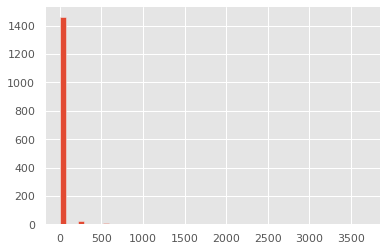

In [152]:
# вся группа А
a_all.rev.hist(bins=50)
sns.despine()

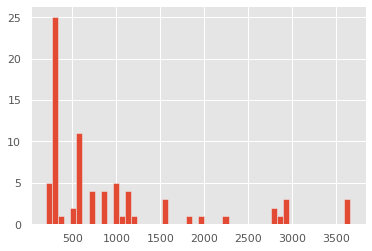

In [153]:
# только купившие в группе А
a_pay.rev.hist(bins=50)
sns.despine()

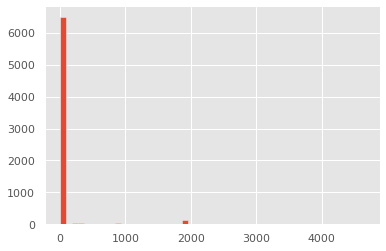

In [154]:
# вся группа В
b_all.rev.hist(bins=50)
sns.despine()

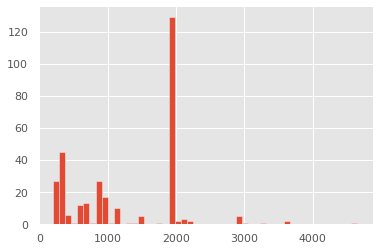

In [155]:
# только купившие в группе В
b_pay.rev.hist(bins=50)
sns.despine()

Распределения в группах не являются нормальными

<b> В группе В оплативших очень много значений около 2000!!!</b>

In [156]:
b_details = b_pay.groupby('rev').agg({'rev':'count'})
b_details.rev.sort_values(ascending=False)

rev
1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
398.0000      6
590.0000      6
580.0000      5
870.0000      5
1530.0000     5
2099.0000     3
2890.0000     3
1980.0000     2
2910.0000     2
3660.0000     2
489.0000      1
597.0000      1
796.0000      1
4650.0000     1
880.0000      1
1050.0000     1
1160.0000     1
1388.0000     1
1729.0000     1
1968.0000     1
2190.0000     1
2220.0000     1
3040.0000     1
3260.0000     1
1339.0000     1
Name: rev, dtype: int64

93 пользователя совершили покупки на 1900 денег. Вероятно, это каким-то образом связано с тестовой активностью.
Возможно, за покупку на такую сумму положены какие-то бонусы. Так же 35 платежей на 1900.0001 - возможно, это какой-то сбой.

In [157]:
# сравню опистальную статистику в общих группах
describe_all = pd.concat([a_all.rev.describe().to_frame().rename(columns={'rev' : 'A'}),\
                          b_all.rev.describe().to_frame().rename(columns={'rev' : 'B'})], axis =1)
describe_all

,A,B
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


In [158]:
# сравню опистальную статистику в группах оплативших
describe_pay = pd.concat([a_pay.rev.describe().to_frame().rename(columns={'rev' : 'A'}),\
                          b_pay.rev.describe().to_frame().rename(columns={'rev' : 'B'})], axis =1)
describe_pay

,A,B
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


Далее посмотрю выбросы

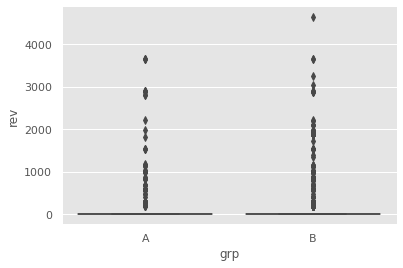

In [159]:
# по всем пользователям
sns.boxplot(data=active_total, y='rev', x='grp')
sns.despine()

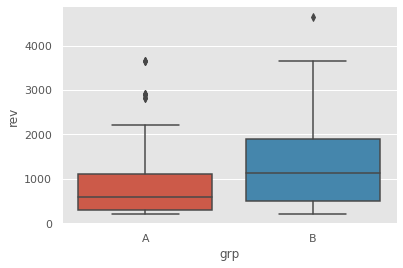

In [160]:
# по оплатившим пользоыателям
sns.boxplot(data=active_total_paid, y='rev', x='grp')
sns.despine()

Есть некоторое количество выбросов, соответсвенно в перспективе нужно это иметь ввиду

<b> Промежуточные итоги #2 </b>

Теперь приступаю к выбору метрик: я предполагаю использовать:

1. Конверсию (CR)

2. Средний доход на пользователя (ARPU)

3. Средний доход на платящего пользователя (ARPPU)

Эти метрики, на мой взгляд, наиболее показательны, и в рамках юнит-экономики позволяют буквально увидель количество денег, которые приносят пользователи, а так же посмотреть, какое количество пользователей отсеивается в процессе. В варианте, где конверсия будет выше, пользователи по неким причинам "лучше" доходят до покупки

In [161]:
# строю вспомогательный даатфрейм для последующего наглядного датафрейма

fin_df = active_total.groupby('grp', as_index=False).agg({'id':'count'}).rename(columns={'id':'users_qty'})
fin_df

,grp,users_qty
0,A,1538
1,B,6803


Сичтаю метрики по группам и собираю в результиурющую табличку для простоты восприятия

In [162]:
# конверсия по группам
fin_df['CR'] = [(a_pay.id.count() / a_all.id.count()).round(3), (b_pay.id.count() / b_all.id.count()).round(3)]

# ARPU по группам
fin_df['ARPU'] = [(a_pay.rev.sum() / a_all.id.count()).round(2), (b_pay.rev.sum() / b_all.id.count()).round(2)]

# ARPPU по группам
fin_df['ARPPU'] = [a_pay.rev.mean().round(2), b_pay.rev.mean().round(2)]

# вывод результирующего датафрейма
fin_df

,grp,users_qty,CR,ARPU,ARPPU
0,A,1538,0.051,47.35,933.59
1,B,6803,0.046,58.06,1257.88


<b> Промежуточный анализ метрик: </b>

Из расчёта видно, что конверсия в группе В ниже, а ARPU и ARPPU выше, чем в А.
Возможно. это связано с тем, что покупателей становится меньше, но покупают они более "эффективно" - либо более дорогие товары, либо бОльшее количество.

Нужна проверка значимости изменений. 

Так как размеры групп отличаются, а так же распределение величин не является нормальным, для проерки значимости я буду использовать методы U_критерия Манна-Уитни и bootstrap.

Построю bootstrap распределения для каждой из групп, определю доверителные интервалы и на основании полученных значений приму решение.

Функцию bootstrap  использую из материалов лекции по АВ тестам

In [163]:
# функция бутстрапа из лекции по АВ тестам
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

<b>Конверсия и гипотезы относительно конверсии:</b>

H0: CR в двух группах одинаковые

H1: CR в двух группах различаются

In [183]:
# сравниваю с помощью U-критерия Манна-Уитни
mannwhitneyu(a_all.pay, b_all.pay)

MannwhitneyuResult(statistic=5255358.0, pvalue=0.4455071016631552)

<b> Вывод по CR </b>

P-value выше 005. Нет оснований отвергать Н0. Видимо, различия конверсии между группами не значимые

<b>ARPU и гипотезы относительно него:</b>

H0: ARPU в двух группах одинаковые

H1: ARPU в двух группах различаются

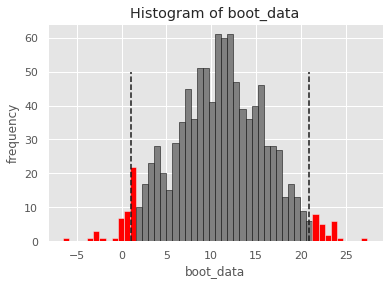

In [165]:
booted_data_arpu = get_bootstrap(b_all.rev, a_all.rev)

In [166]:
booted_data_arpu['quants']

,0
0.025,1.011194
0.975,20.877749


In [167]:
booted_data_arpu['p_value']

0.03518036840477454

<b> Вывод по ARPU </b>

P-value ниже 005, ноль не попадает в доверительный интервал. ARPU между группами статистически значимо различаются

<b>ARPPU и гипотезы относительно него:</b>

H0: ARPPU в двух группах одинаковые

H1: ARPPU в двух группах различаются

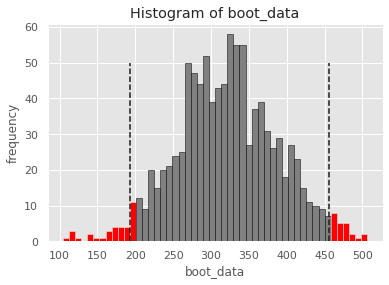

In [168]:
booted_data_arppu = get_bootstrap(b_all.rev[b_all.rev > 0], a_all.rev[a_all.rev > 0])

In [169]:
booted_data_arppu['quants']

,0
0.025,193.74587
0.975,455.78592


In [170]:
booted_data_arppu['p_value']

1.4422014875175574e-06

<b> Вывод по ARPPU </b>

P-value ниже 005, ноль не попадает в доверительный интервал. ARPPU между группами статистически значимо различаются

# Выводы по заданию 1

<em>На какие метрики Вы смотрите в ходе анализа и почему?</em>

В своем исследовании я использовал следующие метрики:

1. Конверсию (CR)

2. Средний доход на пользователя (ARPU)

3. Средний доход на платящего пользователя (ARPPU)

Эти метрики, на мой взгляд, наиболее показательны, и в рамках юнит-экономики позволяют буквально увидель количество денег, которые приносят пользователи, а так же посмотреть, какое количество пользователей отсеивается в процессе. В варианте, где конверсия будет выше, пользователи по неким причинам "лучше" доходят до покупки


<em>Имеются ли различия в показателях и с чем они могут быть связаны?</em>

Из расчёта видно, что конверсия в группе В ниже, чем в А. При этом метрики ARPU И ARPPU в тестовой группе выше, чем в контрольной.
Возможно, это связано с тем, что покупателей становится меньше, но покупают они более "эффективно" - либо более дорогие товары, либо бОльшее количество. В тестовой группе видно большое количество платежей в 1900. Что повышает ARPU и ARPPU


<em>Являются ли эти различия статистически значимыми?</em>

По результату расчётов, различия в конверсии между группами - не значимые, а различия в ARPU И ARPPU - значимые!

<em>Стоит ли запускать новую механику на всех пользователей?</em>

<b>По результату исследования, новую механику стоит запустить на всех пользователей, так как есть положительный прирост ARPU и ARPPU, а снижение конверсии оказалось статистически незначимым.</b>

# Задание 2

1. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

2. Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 

ARPAU 

CR в покупку 

СR активного пользователя в покупку 

CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [171]:
# формирую условия для присоеднения к кликхаус
connection = dict(database='default',
                  host='http://clickhouse.lab.karpov.courses:80',
                  user='student',
                  password='dpo_python_2020')

In [172]:
# запрос на поиск самых усердных студентов
request_1 = '''
            SELECT uniqExact(st_id) as Very_diligent_students_qty
            FROM
            (SELECT st_id, month, COUNT(st_id)
             FROM default.peas
             WHERE correct == 1
             GROUP BY date_trunc ('month', timest) AS month, st_id
             HAVING COUNT() >= 20) '''

In [173]:
# вывод ответа на 1й вопрос как df
sql_1 = ph.read_clickhouse(request_1, connection=connection)
sql_1

,Very_diligent_students_qty
0,136


In [174]:
# запрос на выгрузку ARPU, ARPAU, CR в покупку, CR активного пользователя в покупку, CR пользователя из активности по математике
request_2 = '''
            SELECT 
            test_grp,
            -- делю все деньги на всех пользователей
            ROUND(SUM(money)/uniqExact(studs.st_id), 2) as ARPU,
            -- делю сумму денег, если решено более 10 задач делю на уникальных пользователей, решивших более 10 задач
            ROUND(SUMIf(money, total_peas > 10)/uniqIf(studs.st_id, total_peas > 10), 2) as ARPAU,
            -- делю униакльных оплативших на всех уникальных пользователей
            ROUND(uniqIf(studs.st_id, money > 0)/uniqExact(studs.st_id) * 100, 2) as CR,
            -- делю уникальных оплативших пользователей, решивших более 10 задач на уникальных, решивших более 10 задач
            ROUND(uniqIf(studs.st_id, money > 0 AND total_peas > 10)/uniqIf(studs.st_id, total_peas > 10) * 100, 2) as CR_ACT_USR,
            -- делю уникальных оплативших, решивших 2 или более задачи по математике на решивших 2 или более задачи по математике
            ROUND(uniqIf(studs.st_id, money > 0 AND only_math >= 2 and subject = 'Math')/
            uniqIf(studs.st_id, only_math >= 2) * 100, 2) as CR_MATH
            FROM default.studs
            -- добавляю таблицу с монетизацией по студентам и предметам (без даты)
            LEFT JOIN (
                SELECT 
                  st_id,
                  subject,
                  money
                FROM default.final_project_check
                ) as buys 
                ON studs.st_id = buys.st_id
            -- добавляю таблицу с информацией по студентам и количеству решенных ими задач (без даты) плюс отдельной графой математику
            LEFT JOIN (
                SELECT
                  st_id,
                  SUM(correct) as total_peas,
                  SUMIf(correct, subject = 'Math') as only_math
                FROM default.peas
                GROUP BY st_id
                ) as math_peas 
                ON studs.st_id = math_peas.st_id
            GROUP BY test_grp
            '''

In [175]:
# вывод ответа на 2й вопрос как df
sql_2 = ph.read_clickhouse(request_2, connection=connection)
sql_2

,test_grp,ARPU,ARPAU,CR,CR_ACT_USR,CR_MATH
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


# Задание 3. Python

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [176]:
# функция для сбора данных и подсчёта метрик

def update(groups, groups_add, active_studs, checks):
    '''
    Функция собирает в один датасет основной даатсет и дополнительный, переименовывает колонку с id.
    Затем мерджит активных студентов с данными по оплатам и на основе смердженного датасета считает метрики
    '''
    
    groups_add.columns = groups.columns
    groups = pd.concat([groups, groups_add]).rename(columns={'id': 'student_id'})
    
    active = groups.query('student_id in @active_studs.student_id').merge(checks, how='left', on='student_id').fillna(0)
    
    metrics = active.groupby('grp', as_index=False).agg(users_qty=('student_id', 'count'),
                        CR=('rev', lambda x: np.mean(x > 0)),
                        ARPU=('rev', 'mean'),
                        ARPPU=('rev', lambda x: np.mean(pd.Series(x).loc[lambda x: x > 0])))
    return metrics.round(3)

In [177]:
# вывод метрик через функцию

update(groups, groups_add, active_studs, checks)

,grp,users_qty,CR,ARPU,ARPPU
0,A,1538,0.051,47.347,933.590
1,B,6803,0.046,58.059,1257.879


In [178]:
# функция для вывода метрик графически

def graph(update):
    '''
    Функция создаёт графики метрик, пересчитанных функцией update_m()
    '''
    
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(ncols=3, figsize=(20, 10))

    sns.barplot(x="grp", y="CR", data=update, ax=axs[0]).set_title('CR')
    sns.barplot(x="grp", y="ARPU", data=update, ax=axs[1]).set_title('ARPU')
    sns.barplot(x="grp", y="ARPPU", data=update, ax=axs[2]).set_title('ARPPU')

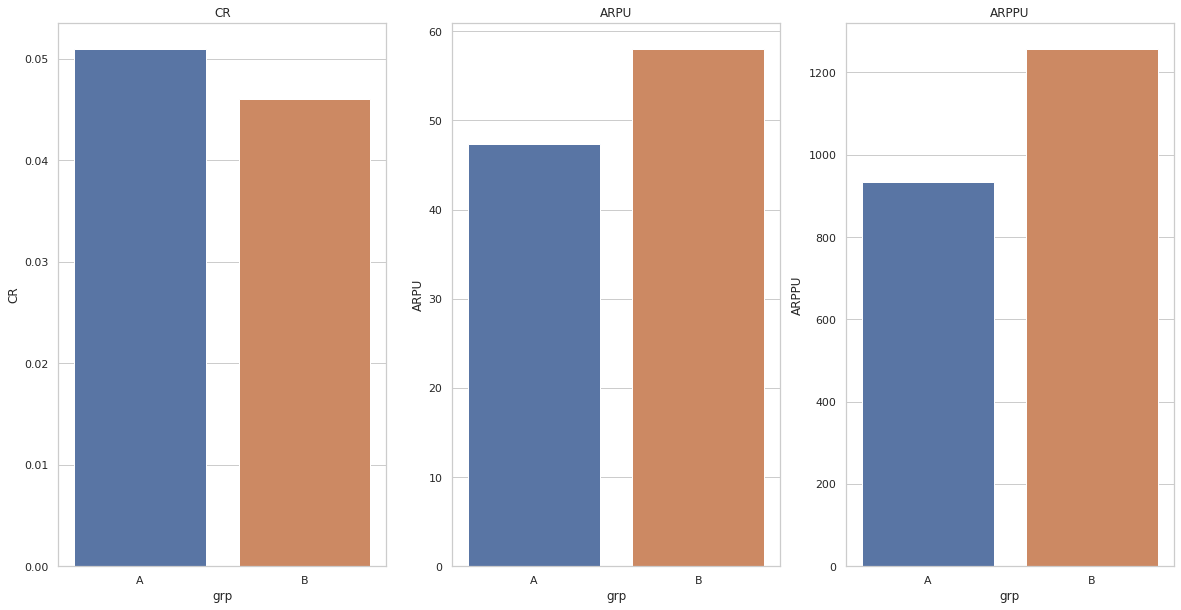

In [179]:
# вывод графиков

graph(update(groups, groups_add, active_studs, checks))